In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, \
                        BatchNormalization, Conv2D, MaxPooling2D, Concatenate, Add, Conv1D
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, np_utils
from keras import callbacks

import json
import pickle
from datetime import datetime, timedelta

# helper functions

In [2]:
city = 'cairo'

In [3]:
if city=='cairo' or 'amman':
    num_classes = 3
else:
    num_classes = 5

In [4]:
def getHistorical(date, longitude, city):
    if city=='cairo':
        sheet = 'Egypt'
    elif city=='amman':
        sheet = 'Jordan'
    elif city=='delhi':
        sheet = 'India'
    else:
        print('invalid city')
        return None
    
    df = pd.read_excel('google_trends.xlsx', sheet_name=sheet, converters={'Date':str})
    for i in df.index:
        if(df['Date'][i]==date+' 00:00:00'):
            res = []
            for x in range(longitude):
                res.append(df['ACLED'][i-longitude])
                i += 1
            return res

In [5]:
def getIndicators(date, city, longitude, indicator):
    df = pd.read_excel('other_indicators.xlsx', sheet_name=city, converters={'Date':str})
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        for i in df.index:
            if(str(df['Date'][i]).startswith(days1[x][0:7])):
                res.append(round(float(df[indicator][i]), 2))
    return res

In [7]:
def getCommodity(date, city, longitude, indicator):
    if city=='cairo':
        sheet = 'Egypt'
    elif city=='amman':
        sheet = 'Jordan'
    elif city=='delhi':
        sheet = 'India'
    else:
        print('invalid city')
        return None
    
    df = pd.read_excel('Book1.xlsx', sheet_name=sheet, converters={'Date':str})
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        for i in df.index:
            if(str(df['Date'][i]).startswith(days1[x][0:7])):
                res.append(round(float(df[indicator][i]), 2))
    return res

In [8]:
def getWeather(date, city, longitude, category):
    with open('/'+city+'/weather-dic.json') as f:
        weather = json.load(f)
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        res.append(weather[days1[x]]['hourly'][0][category])
    return res

In [112]:
def getHateSpeech(date, city, longitude):
    with open('/'+city+'/hate_rate.json') as f:
        rate = json.load(f)
    start_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=longitude)
    end_date = datetime.strptime(date, '%Y-%m-%d')-timedelta(days=1)
    days = [start_date + timedelta(days=x) for x in range((end_date-start_date).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    res = []
    for x in range(len(days1)-1):
        res.append(rate[days1[x]])
    return res

In [11]:
def twitterSentiment(date, longitude, city):
    if city=='cairo':
        path = ''
    elif city=='amman':
        path = ''
    elif city=='delhi':
        path = ''
    df = pd.read_excel(path, sheet_name='Social unrest events prediction', converters={'Analysis Date':str})
    for i in df.index:
        if(df['Analysis Date'][i]==date+' 00:00:00'):
            res = []
            for x in range(longitude):
                res.append(df['Anger'][i-longitude])
                i += 1
            return res

In [12]:
def twitterVolume(date, longitude, city):
    if city=='cairo':
        path = ''
    elif city=='amman':
        path = ''
    elif city=='delhi':
        path = ''
    df = pd.read_excel(path, sheet_name='Social unrest events prediction', converters={'Date':str})
    for i in df.index:
        if(df['Date'][i]==date+' 00:00:00'):
            res = []
            for x in range(longitude):
                res.append(df['Relevant Posts'][i-longitude])
                i += 1
            return res

In [13]:
def loadTruth(city):
    if city=='cairo':
        path = ''
    elif city=='amman':
        path = ''
    elif city=='delhi':
        path = ''
    else:
        print('invalid city')
        return None
    
    with open(path) as f:
        data = json.load(f)
    return data

In [14]:
truths = loadTruth(city)
for date in truths.keys():
    truths[date] = np_utils.to_categorical(truths[date], num_classes=num_classes)

In [190]:
# create hist dataset - training
def createIndicatorTrain(longitude, lap, city, indicators):
    if city=='cairo':
        if longitude == 60:
            start_date = '2015-06-01'
        else:
            start_date = '2015-05-01'
    elif city=='amman':
        start_date = '2016-01-01'
    elif city=='delhi':
        start_date = '2016-01-01'
    else:
        print('invalid city')
        return None

    end_date = '2019-01-01'

    days_min = datetime.strptime(start_date, '%Y-%m-%d')
    days_max = datetime.strptime(end_date, '%Y-%m-%d')
    days = [days_min + timedelta(days=x) for x in range((days_max-days_min).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]

    res = {}
    for i in range(len(days1)-1):
        indic = []
        date = days1[i]
        print(date)
        for indicator in indicators:
            if indicator == 'hist':
                indic.append(getHistorical(date, longitude, city))
            elif indicator == 'precipMM' or indicator == 'tempF':
                indic.append(getWeather(date, city, longitude, indicator))
            elif indicator == 'twitter sentiment':
                indic.append(twitterSentiment(date, longitude, city))
            elif indicator == 'twitter volume':
                indic.append(twitterVolume(date, longitude, city))
            elif indicator == 'Cotton' or indicator == 'Rice' or indicator == 'Wheat' or indicator == 'Maize' or indicator == 'Sugar' or indicator == 'Gold' or indicator == 'Natrual gas' or indicator == 'Iron ore' or indicator =='Copper':
                indic.append(getCommodity(date, city, longitude, indicator))
            elif indicator == 'hate':
                indic.append(getHateSpeech(date, city, longitude))
            else:
                indic.append(getIndicators(date, city, longitude, indicator))
        lengths = [len(feature) for feature in indic]
        total_points = sum(lengths)
        vector = np.zeros((total_points, 2), dtype=np.float32)
        current = 0
        for feature in indic:
            vector[current:(current + len(feature)),0] = feature
            current += len(feature)
            vector[current - 1, 1] = 1  # stroke_end
        # Preprocessing.
        # 1. Size normalization.
        lower = np.min(vector[:, 0:1], axis=0)
        upper = np.max(vector[:, 0:1], axis=0)
        scale = upper - lower
        scale[scale == 0] = 1
        vector[:, 0:1] = (vector[:, 0:1] - lower) / scale
        # 2. Compute deltas.
        vector[1:, 0:1] -= vector[0:-1, 0:1]
        vector = vector[1:, :]
        
        current = (datetime.strptime(date, '%Y-%m-%d')+timedelta(days=lap)).strftime('%Y-%m-%d')
        res[current] = vector
    return res, len(vector)

In [256]:
longitude = 60
lap = 7

In [257]:
indicators = ['Maize', 'Natrual gas', 'CPI Price, seas. adj.', 'Exchange rate', 'Stock Markets', 'Unemployment Rate', 'tempF', 'precipMM', 'twitter sentiment', 'twitter volume', 'hist']

In [ ]:
x_indic, input_len = createIndicatorTrain(longitude, lap, city, indicators)

In [118]:
def preprocess(img):
    x = img[:30]
    return x

In [71]:
# Function to encode the data for a given date into (30, 300, longitude)
def encode(img, date, longitude, lap):
    res = np.zeros(shape=(30, 300, longitude))
    days = [datetime.strptime(date, '%Y-%m-%d') - timedelta(days=x) for x in range(lap, longitude+lap)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]
    days1.reverse()
    for i in range(len(days1)-1):
        print(days1[i])
        image = img[str.encode(days1[i])]
        image = preprocess(image) # crop the image
        res[:,:,i] = image
    return res

In [27]:
images = ''
# Load tweet matrix
with open(images, 'rb') as f:
    img = pickle.load(f, encoding='bytes')

In [260]:
tweet_longitude = 60
tweet_lap = 7

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
x_tweet = {}
for t in x_indic.keys():
    encoded = encode(img, t, tweet_longitude, tweet_lap)
    encoded = np.expand_dims(encoded, axis=3)
    x_tweet[t] = np.moveaxis(encoded, 2, 0)
print(x_tweet[t].shape)
print("Time taken in seconds =", time()-start)

In [291]:
# check shape
print(x_tweet['2016-01-01'].shape)
print(x_indic['2016-01-01'].shape)
print(truths['2015-06-20'])

(60, 30, 300, 1)
(659, 2)
[0. 0. 1.]


# build model

In [292]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(hists, tweets, truths, num_samples_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over samples
    while 1:
        for key in hists.keys():
            n+=1
            # retrieve the photo feature
            tweet = tweets[key]
            hist = np.asarray(hists[key])
            truth = truths[key]
            
            hist = np.expand_dims(hist, axis=1)
            
            X1.append(tweet)
            X2.append(hist)
            y.append(truth)
            # yield the batch data
            if n==num_samples_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [293]:
tweet_model = Sequential()
#use cnn to learn festures
tweet_model.add(TimeDistributed(Conv2D(1, kernel_size=5, strides=1, activation='relu'), input_shape=(tweet_longitude,30, 300,1)))
# tweet_model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))))
tweet_model.add(TimeDistributed(Dropout(0.3)))
tweet_model.add(TimeDistributed(Conv2D(1, kernel_size=5, strides=1, activation='relu')))
tweet_model.add(TimeDistributed(Dropout(0.3)))
tweet_model.add(TimeDistributed(Conv2D(1, kernel_size=3, strides=1, activation='relu')))
tweet_model.add(TimeDistributed(Dropout(0.3)))
# tweet_model.add(TimeDistributed(Conv2D(1, (5, 5), activation='relu')))
# tweet_model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
tweet_model.add(TimeDistributed(Flatten()))
tweet_model.add(TimeDistributed(Dense(128, activation='relu')))
tweet_model.add(LSTM(128))


#lstm
hist_model = Sequential()
hist_model.add(Conv1D(filters=48, kernel_size=5, strides=1, padding='same', input_shape=(input_len,2)))
hist_model.add(Dropout(0.3))
hist_model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding='same'))
hist_model.add(Dropout(0.3))
# hist_model.add(Conv1D(filters=96, kernel_size=3, strides=1, padding='same'))
# hist_model.add(Dropout(0.3))
hist_model.add(LSTM(128))
# hist_model.add(Flatten())
hist_model.add(Dense(128, activation='relu'))

#concatenate
decoder1 = Add()([tweet_model.output, hist_model.output])
decoder2 = Dense(128, activation='relu')(decoder1)
outputs = Dense(num_classes, activation='softmax')(decoder2)
model = Model(inputs=[tweet_model.input, hist_model.input], outputs=outputs)

In [ ]:
model.summary()

# early stopping

In [269]:
callbacks_list = [
    callbacks.ModelCheckpoint(
        filepath='/'+city+'/best_model_'+str(longitude)+'days'+str(lap)+'lap_'+str(tweet_longitude)+'days'+str(tweet_lap)+'lap.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    callbacks.EarlyStopping(monitor='acc', patience=5)
]

In [270]:
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [271]:
model.optimizer.learning_rate = 0.0001

In [272]:
BATCH_SIZE = 8
EPOCHS = 50

In [273]:
# convert dict to list
X1, X2, y = list(), list(), list()
for key in x_indic.keys():
    tweet = x_tweet[key]
    hist = x_indic[key]
    truth = truths[key]

    X1.append(tweet)
    X2.append(hist)
    y.append(truth)
x_train = [array(X1), array(X2)]
y_train = array(y)

In [274]:
print(x_train[0].shape)
print(x_train[1].shape)

(1311, 60, 30, 300, 1)
(1311, 659, 2)


In [ ]:
history = model.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

# prediction

In [277]:
# create hist dataset - training
def createIndicatorTest(longitude, lap, city, indicators):
    start_date = '2019-01-01'
    end_date = '2019-02-23'

    days_min = datetime.strptime(start_date, '%Y-%m-%d')
    days_max = datetime.strptime(end_date, '%Y-%m-%d')
    days = [days_min + timedelta(days=x) for x in range((days_max-days_min).days + 2)]
    days1 = [x.strftime('%Y-%m-%d') for x in days]

    res = {}
    for i in range(len(days1)-1):
        indic = []
        date = days1[i]
        print(date)
        for indicator in indicators:
            if indicator == 'hist':
                indic.append(getHistorical(date, longitude, city))
            elif indicator == 'precipMM' or indicator == 'tempF':
                indic.append(getWeather(date, city, longitude, indicator))
            elif indicator == 'twitter sentiment':
                indic.append(twitterSentiment(date, longitude, city))
            elif indicator == 'twitter volume':
                indic.append(twitterVolume(date, longitude, city))
            elif indicator == 'Cotton' or indicator == 'Rice' or indicator == 'Wheat' or indicator == 'Maize' or indicator == 'Sugar' or indicator == 'Gold' or indicator == 'Natrual gas' or indicator == 'Iron ore' or indicator =='Copper':
                indic.append(getCommodity(date, city, longitude, indicator))
            elif indicator == 'hate':
                indic.append(getHateSpeech(date, city, longitude))
            else:
                indic.append(getIndicators(date, city, longitude, indicator))
        lengths = [len(feature) for feature in indic]
        total_points = sum(lengths)
        vector = np.zeros((total_points, 2), dtype=np.float32)
        current = 0
        for feature in indic:
            vector[current:(current + len(feature)),0] = feature
            current += len(feature)
            vector[current - 1, 1] = 1  # stroke_end
        # Preprocessing.
        # 1. Size normalization.
        lower = np.min(vector[:, 0:1], axis=0)
        upper = np.max(vector[:, 0:1], axis=0)
        scale = upper - lower
        scale[scale == 0] = 1
        vector[:, 0:1] = (vector[:, 0:1] - lower) / scale
        # 2. Compute deltas.
        vector[1:, 0:1] -= vector[0:-1, 0:1]
        vector = vector[1:, :]
        
        current = (datetime.strptime(date, '%Y-%m-%d')+timedelta(days=lap)).strftime('%Y-%m-%d')
        res[current] = vector
    return res

In [ ]:
y_indic = createIndicatorTest(longitude, lap, city, indicators)

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
y_tweet = {}
for t in y_indic.keys():
    encoded = encode(img, t, tweet_longitude, tweet_lap)
    encoded = np.expand_dims(encoded, axis=3)
    y_tweet[t] = np.moveaxis(encoded, 2, 0)
print(y_tweet[t].shape)
print("Time taken in seconds =", time()-start)

In [280]:
# convert dict to list
X1, X2, y = list(), list(), list()
for key in y_indic.keys():
    tweet = y_tweet[key]
    hist = y_indic[key]
    truth = truths[key]
    
    X1.append(tweet)
    X2.append(hist)
    y.append(truth)
x_test = [array(X1), array(X2)]
y_test = array(y)

In [281]:
# check shape
print(x_test[0].shape)
print(x_test[1].shape)
print(truths['2019-01-01'])

(54, 60, 30, 300, 1)
(54, 659, 2)
[1. 0. 0.]


In [283]:
predicted = model.predict(x_test)

In [284]:
y_score = predicted

In [285]:
# save output
with open('/'+city+'/output/'+str(longitude)+'days'+str(lap)+'lap_'+str(tweet_longitude)+'days'+str(tweet_lap)+'lap.pickle', 'wb') as output_file:
    pickle.dump([y_test, y_score], output_file)

# plot graphs

In [ ]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [367]:
longitude = 30
lap = 7
tweet_longitude = 30
tweet_lap = 7

In [368]:
with open('/'+city+'/output/'+str(longitude)+'days'+str(lap)+'lap_'+str(tweet_longitude)+'days'+str(tweet_lap)+'lap.pickle', 'rb') as output_file:
    [y_test2, y_score2] = pickle.load(output_file)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

n_classes = 3
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
# Compute ROC curve and ROC area for each class
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
for i in range(3):
    fpr1[i], tpr1[i], _ = roc_curve(y_test1[:, i], y_score1[:, i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])

# Compute micro-average ROC curve and ROC area
fpr1["micro"], tpr1["micro"], _ = roc_curve(y_test1.ravel(), y_score1.ravel())
roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])

all_fpr1 = np.unique(np.concatenate([fpr1[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr1 = np.zeros_like(all_fpr1)
for i in range(n_classes):
    mean_tpr1 += interp(all_fpr1, fpr1[i], tpr1[i])

# Finally average it and compute AUC
mean_tpr1 /= n_classes

fpr1["macro"] = all_fpr1
tpr1["macro"] = mean_tpr1
roc_auc1["macro"] = auc(fpr1["macro"], tpr1["macro"])

In [ ]:
# Compute ROC curve and ROC area for each class
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
for i in range(3):
    fpr2[i], tpr2[i], _ = roc_curve(y_test2[:, i], y_score2[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])

# Compute micro-average ROC curve and ROC area
fpr2["micro"], tpr2["micro"], _ = roc_curve(y_test2.ravel(), y_score2.ravel())
roc_auc2["micro"] = auc(fpr2["micro"], tpr2["micro"])

all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr2 = np.zeros_like(all_fpr2)
for i in range(n_classes):
    mean_tpr2 += interp(all_fpr2, fpr2[i], tpr2[i])

# Finally average it and compute AUC
mean_tpr2 /= n_classes

fpr2["macro"] = all_fpr2
tpr2["macro"] = mean_tpr2
roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

In [ ]:
# Compute ROC curve and ROC area for each class
fpr3 = dict()
tpr3 = dict()
roc_auc3 = dict()
for i in range(3):
    fpr3[i], tpr3[i], _ = roc_curve(y_test3[:, i], y_score3[:, i])
    roc_auc3[i] = auc(fpr3[i], tpr3[i])

# Compute micro-average ROC curve and ROC area
fpr3["micro"], tpr3["micro"], _ = roc_curve(y_test3.ravel(), y_score3.ravel())
roc_auc3["micro"] = auc(fpr3["micro"], tpr3["micro"])

all_fpr3 = np.unique(np.concatenate([fpr3[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr3 = np.zeros_like(all_fpr3)
for i in range(n_classes):
    mean_tpr3 += interp(all_fpr3, fpr3[i], tpr3[i])

# Finally average it and compute AUC
mean_tpr3 /= n_classes

fpr3["macro"] = all_fpr3
tpr3["macro"] = mean_tpr3
roc_auc3["macro"] = auc(fpr3["macro"], tpr3["macro"])

In [ ]:
# Compute ROC curve and ROC area for each class
fpr4 = dict()
tpr4 = dict()
roc_auc4 = dict()
for i in range(3):
    fpr4[i], tpr4[i], _ = roc_curve(y_test4[:, i], y_score4[:, i])
    roc_auc4[i] = auc(fpr4[i], tpr4[i])

# Compute micro-average ROC curve and ROC area
fpr4["micro"], tpr4["micro"], _ = roc_curve(y_test4.ravel(), y_score4.ravel())
roc_auc4["micro"] = auc(fpr4["micro"], tpr4["micro"])

all_fpr4 = np.unique(np.concatenate([fpr4[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr4 = np.zeros_like(all_fpr4)
for i in range(n_classes):
    mean_tpr4 += interp(all_fpr4, fpr4[i], tpr4[i])

# Finally average it and compute AUC
mean_tpr4 /= n_classes

fpr4["macro"] = all_fpr4
tpr4["macro"] = mean_tpr4
roc_auc4["macro"] = auc(fpr4["macro"], tpr4["macro"])

In [ ]:
# Compute ROC curve and ROC area for each class
fpr5 = dict()
tpr5 = dict()
roc_auc5 = dict()
for i in range(3):
    fpr5[i], tpr5[i], _ = roc_curve(y_test5[:, i], y_score5[:, i])
    roc_auc5[i] = auc(fpr5[i], tpr5[i])

# Compute micro-average ROC curve and ROC area
fpr5["micro"], tpr5["micro"], _ = roc_curve(y_test5.ravel(), y_score5.ravel())
roc_auc5["micro"] = auc(fpr5["micro"], tpr5["micro"])

all_fpr5 = np.unique(np.concatenate([fpr5[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr5 = np.zeros_like(all_fpr5)
for i in range(n_classes):
    mean_tpr5 += interp(all_fpr5, fpr5[i], tpr5[i])

# Finally average it and compute AUC
mean_tpr5 /= n_classes

fpr5["macro"] = all_fpr5
tpr5["macro"] = mean_tpr5
roc_auc5["macro"] = auc(fpr5["macro"], tpr5["macro"])

In [360]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import label_binarize

In [ ]:
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
series = read_csv('', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
X = series.values.astype('float32')
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)

y_score6 = []
y_test6 = []
for i in range(len(predictions)):
	predicted = predictions[i]
	if predicted > 0:
		predicted = 1
	else:
		predicted = 0
	actual = np.rint(test[i])
	if test[i]>1:
		actual = 2
	y_score6.append(predicted)
	y_test6.append(actual)

y_score6 = label_binarize(y_score6, classes=[0, 1, 2])
y_test6 = label_binarize(y_test6, classes=[0, 1, 2])


# Compute ROC curve and ROC area for each class
fpr6 = dict()
tpr6 = dict()
roc_auc6 = dict()
for i in range(3):
    fpr6[i], tpr6[i], _ = roc_curve(y_test6[:, i], y_score6[:, i])
    roc_auc6[i] = auc(fpr6[i], tpr6[i])

# Compute micro-average ROC curve and ROC area
fpr6["micro"], tpr6["micro"], _ = roc_curve(y_test6.ravel(), y_score6.ravel())
roc_auc6["micro"] = auc(fpr6["micro"], tpr6["micro"])

n_classes = 2
all_fpr6 = np.unique(np.concatenate([fpr6[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr6 = np.zeros_like(all_fpr6)
for i in range(n_classes):
    mean_tpr6 += interp(all_fpr6, fpr6[i], tpr6[i])

# Finally average it and compute AUC
mean_tpr6 /= n_classes

fpr6["macro"] = all_fpr6
tpr6["macro"] = mean_tpr6
roc_auc6["macro"] = auc(fpr6["macro"], tpr6["macro"])

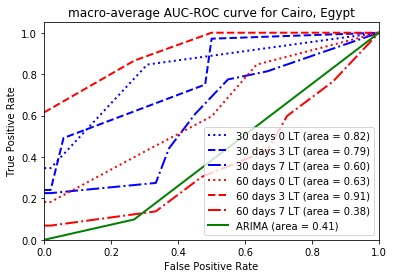

In [375]:
plt.figure()
lw = 2
plt.plot(fpr['macro'], tpr['macro'], color='blue',
         lw=lw, label='30 days 0 LT (area = %0.2f)' % roc_auc['macro'], linestyle=':')
plt.plot(fpr1['macro'], tpr1['macro'], color='blue',
         lw=lw, label='30 days 3 LT (area = %0.2f)' % roc_auc1['macro'], linestyle='--')
plt.plot(fpr2['macro'], tpr2['macro'], color='blue',
         lw=lw, label='30 days 7 LT (area = %0.2f)' % roc_auc2['macro'], linestyle='-.')
plt.plot(fpr3['macro'], tpr3['macro'], color='red',
         lw=lw, label='60 days 0 LT (area = %0.2f)' % roc_auc3['macro'], linestyle=':')
plt.plot(fpr4['macro'], tpr4['macro'], color='red',
         lw=lw, label='60 days 3 LT (area = %0.2f)' % roc_auc4['macro'], linestyle='--')
plt.plot(fpr5['macro'], tpr5['macro'], color='red',
         lw=lw, label='60 days 7 LT (area = %0.2f)' % roc_auc5['macro'], linestyle='-.')
plt.plot(fpr6['macro'], tpr6['macro'], color='green',
         lw=lw, label='ARIMA (area = %0.2f)' % roc_auc6['macro'])
# plt.plot([0, 1], [0, 1], color='green', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('macro-average AUC-ROC curve for Cairo, Egypt')
plt.legend(loc="lower right")
plt.savefig('./cairo.pdf')